# Exercise Sheet 8

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop

## GAN

The aim of this exercise is to implement a GAN architecture and to test it on the polynomial dataset from the previous exercise sheets. You can adapt the architecture from the MNIST example in the lectures.  
$\star$ Update your loss function to implement a Wasserstein GAN.  
Note that in case you do not have a local environment where you can calculate on a GPU, you can calculate online on collab on a GPU.

The references are: [GAN](https://arxiv.org/abs/1406.2661), [WGAN](https://arxiv.org/abs/1701.07875)

### Solution

In [2]:
!mkdir images

In [3]:
# Polynomial data

size = 40

# evaluate polynomial over grid of size 40x40
def polynomial(degree):
    coeff = np.random.normal(0,1,(degree+1, degree+1))
    #coeff = np.random.uniform(-1,1,(degree+1, degree+1))
    return [[sum([coeff[i,j]*((x/size)**i)*((y/size)**j)
            for i in range(degree+1) for j in range(degree+1) if (i+j)<=degree]) 
            for x in range(size)] for y in range(size)]

# training set of polynomial images of degree <=5
maxdegree = 5
size = 40
num_polys = 20000
polydata = np.array([polynomial(np.random.randint(0,maxdegree)) for i in range(num_polys)])
polydata = tf.keras.utils.normalize(polydata)
np.save('polydata.npy', polydata)

In [4]:
polydata = np.load('polydata.npy')

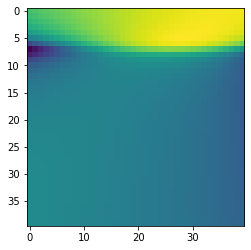

In [5]:
plt.imshow(polydata[1])

In [6]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 40
        self.img_cols = 40
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 2

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 10 * 10, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((10, 10, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        X_train = polydata

        # Rescale -1 to 1
        # X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/poly_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
dcgan.train(epochs=4000, batch_size=32, save_interval=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20, 20, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 32)        0

64 [D loss: 0.063712, acc.: 100.00%] [G loss: 0.325210]
65 [D loss: 0.015026, acc.: 100.00%] [G loss: 0.277482]
66 [D loss: 0.020349, acc.: 100.00%] [G loss: 0.209092]
67 [D loss: 0.018776, acc.: 100.00%] [G loss: 0.247779]
68 [D loss: 0.012904, acc.: 100.00%] [G loss: 0.320748]
69 [D loss: 0.016511, acc.: 100.00%] [G loss: 0.243699]
70 [D loss: 0.321020, acc.: 84.38%] [G loss: 0.068949]
71 [D loss: 0.100295, acc.: 95.31%] [G loss: 0.049279]
72 [D loss: 0.029336, acc.: 100.00%] [G loss: 0.087797]
73 [D loss: 0.016940, acc.: 100.00%] [G loss: 0.283543]
74 [D loss: 0.018097, acc.: 100.00%] [G loss: 0.136905]
75 [D loss: 0.017068, acc.: 100.00%] [G loss: 0.187446]
76 [D loss: 0.008368, acc.: 100.00%] [G loss: 0.247383]
77 [D loss: 0.005511, acc.: 100.00%] [G loss: 0.211873]
78 [D loss: 0.025613, acc.: 100.00%] [G loss: 0.431217]
79 [D loss: 0.002162, acc.: 100.00%] [G loss: 0.494330]
80 [D loss: 0.006952, acc.: 100.00%] [G loss: 0.588729]
81 [D loss: 0.002128, acc.: 100.00%] [G loss: 0.41

209 [D loss: 0.001091, acc.: 100.00%] [G loss: 0.171646]
210 [D loss: 0.001029, acc.: 100.00%] [G loss: 0.114093]
211 [D loss: 0.001002, acc.: 100.00%] [G loss: 0.135894]
212 [D loss: 0.000894, acc.: 100.00%] [G loss: 0.166460]
213 [D loss: 0.000786, acc.: 100.00%] [G loss: 0.083445]
214 [D loss: 0.000712, acc.: 100.00%] [G loss: 0.104448]
215 [D loss: 0.001021, acc.: 100.00%] [G loss: 0.079845]
216 [D loss: 0.001032, acc.: 100.00%] [G loss: 0.104985]
217 [D loss: 0.001966, acc.: 100.00%] [G loss: 0.116550]
218 [D loss: 0.002626, acc.: 100.00%] [G loss: 0.120649]
219 [D loss: 0.000989, acc.: 100.00%] [G loss: 0.062272]
220 [D loss: 0.000629, acc.: 100.00%] [G loss: 0.086689]
221 [D loss: 0.000507, acc.: 100.00%] [G loss: 0.090014]
222 [D loss: 0.001260, acc.: 100.00%] [G loss: 0.094528]
223 [D loss: 0.002311, acc.: 100.00%] [G loss: 0.081682]
224 [D loss: 0.000819, acc.: 100.00%] [G loss: 0.086588]
225 [D loss: 0.000955, acc.: 100.00%] [G loss: 0.086961]
226 [D loss: 0.001068, acc.: 10

353 [D loss: 0.000449, acc.: 100.00%] [G loss: 0.053539]
354 [D loss: 0.000703, acc.: 100.00%] [G loss: 0.149603]
355 [D loss: 0.000641, acc.: 100.00%] [G loss: 0.111782]
356 [D loss: 0.001610, acc.: 100.00%] [G loss: 0.142709]
357 [D loss: 0.000838, acc.: 100.00%] [G loss: 0.122402]
358 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.093836]
359 [D loss: 0.000549, acc.: 100.00%] [G loss: 0.131647]
360 [D loss: 0.000710, acc.: 100.00%] [G loss: 0.119225]
361 [D loss: 0.000561, acc.: 100.00%] [G loss: 0.158079]
362 [D loss: 0.000661, acc.: 100.00%] [G loss: 0.095894]
363 [D loss: 0.000536, acc.: 100.00%] [G loss: 0.091794]
364 [D loss: 0.000501, acc.: 100.00%] [G loss: 0.086526]
365 [D loss: 0.000571, acc.: 100.00%] [G loss: 0.088196]
366 [D loss: 0.001907, acc.: 100.00%] [G loss: 0.099757]
367 [D loss: 0.000434, acc.: 100.00%] [G loss: 0.090748]
368 [D loss: 0.000462, acc.: 100.00%] [G loss: 0.150783]
369 [D loss: 0.000608, acc.: 100.00%] [G loss: 0.121862]
370 [D loss: 0.000380, acc.: 10

497 [D loss: 0.000849, acc.: 100.00%] [G loss: 0.139240]
498 [D loss: 0.000127, acc.: 100.00%] [G loss: 0.232292]
499 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.121678]
500 [D loss: 0.000230, acc.: 100.00%] [G loss: 0.173584]
501 [D loss: 0.001261, acc.: 100.00%] [G loss: 0.144078]
502 [D loss: 0.000395, acc.: 100.00%] [G loss: 0.224101]
503 [D loss: 0.000859, acc.: 100.00%] [G loss: 0.192812]
504 [D loss: 0.000233, acc.: 100.00%] [G loss: 0.090334]
505 [D loss: 0.000711, acc.: 100.00%] [G loss: 0.125723]
506 [D loss: 0.000473, acc.: 100.00%] [G loss: 0.171665]
507 [D loss: 0.000303, acc.: 100.00%] [G loss: 0.224874]
508 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.218381]
509 [D loss: 0.000293, acc.: 100.00%] [G loss: 0.128384]
510 [D loss: 0.000124, acc.: 100.00%] [G loss: 0.084911]
511 [D loss: 0.000150, acc.: 100.00%] [G loss: 0.164102]
512 [D loss: 0.000312, acc.: 100.00%] [G loss: 0.216499]
513 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.146794]
514 [D loss: 0.000220, acc.: 10

641 [D loss: 0.000358, acc.: 100.00%] [G loss: 0.097882]
642 [D loss: 0.000159, acc.: 100.00%] [G loss: 0.309765]
643 [D loss: 0.000146, acc.: 100.00%] [G loss: 0.146337]
644 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.085500]
645 [D loss: 0.000395, acc.: 100.00%] [G loss: 0.176333]
646 [D loss: 0.000128, acc.: 100.00%] [G loss: 0.141298]
647 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.168344]
648 [D loss: 0.000202, acc.: 100.00%] [G loss: 0.212601]
649 [D loss: 0.000148, acc.: 100.00%] [G loss: 0.097786]
650 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.149686]
651 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.120558]
652 [D loss: 0.000178, acc.: 100.00%] [G loss: 0.183834]
653 [D loss: 0.000098, acc.: 100.00%] [G loss: 0.148190]
654 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.231062]
655 [D loss: 0.000079, acc.: 100.00%] [G loss: 0.154283]
656 [D loss: 0.000139, acc.: 100.00%] [G loss: 0.130696]
657 [D loss: 0.000154, acc.: 100.00%] [G loss: 0.167465]
658 [D loss: 0.000164, acc.: 10

785 [D loss: 0.000113, acc.: 100.00%] [G loss: 0.168832]
786 [D loss: 0.000116, acc.: 100.00%] [G loss: 0.178122]
787 [D loss: 0.000077, acc.: 100.00%] [G loss: 0.092087]
788 [D loss: 0.000099, acc.: 100.00%] [G loss: 0.222815]
789 [D loss: 0.000260, acc.: 100.00%] [G loss: 0.142884]
790 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.156180]
791 [D loss: 0.000947, acc.: 100.00%] [G loss: 0.114435]
792 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.157430]
793 [D loss: 0.000120, acc.: 100.00%] [G loss: 0.181017]
794 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.205919]
795 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.131357]
796 [D loss: 0.000215, acc.: 100.00%] [G loss: 0.122113]
797 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.241270]
798 [D loss: 0.000151, acc.: 100.00%] [G loss: 0.232053]
799 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.279708]
800 [D loss: 0.000300, acc.: 100.00%] [G loss: 0.193911]
801 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.136777]
802 [D loss: 0.000063, acc.: 10

929 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.198596]
930 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.120341]
931 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.245439]
932 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.161837]
933 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.158679]
934 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.159695]
935 [D loss: 0.000224, acc.: 100.00%] [G loss: 0.315720]
936 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.157794]
937 [D loss: 0.000083, acc.: 100.00%] [G loss: 0.234276]
938 [D loss: 0.000085, acc.: 100.00%] [G loss: 0.224030]
939 [D loss: 0.000223, acc.: 100.00%] [G loss: 0.313560]
940 [D loss: 0.000092, acc.: 100.00%] [G loss: 0.248547]
941 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.176971]
942 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.319380]
943 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.217896]
944 [D loss: 0.000106, acc.: 100.00%] [G loss: 0.310492]
945 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.189101]
946 [D loss: 0.000149, acc.: 10

1072 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.188550]
1073 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.142423]
1074 [D loss: 0.000187, acc.: 100.00%] [G loss: 0.232120]
1075 [D loss: 0.000057, acc.: 100.00%] [G loss: 0.153589]
1076 [D loss: 0.000053, acc.: 100.00%] [G loss: 0.149942]
1077 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.131057]
1078 [D loss: 0.000046, acc.: 100.00%] [G loss: 0.192592]
1079 [D loss: 0.000097, acc.: 100.00%] [G loss: 0.136785]
1080 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.177463]
1081 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.219355]
1082 [D loss: 0.000081, acc.: 100.00%] [G loss: 0.236268]
1083 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.192250]
1084 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.146808]
1085 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.169655]
1086 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.211194]
1087 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.132203]
1088 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.174947]
1089 [D loss: 

1214 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.099076]
1215 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.138290]
1216 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.190067]
1217 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.320991]
1218 [D loss: 0.000104, acc.: 100.00%] [G loss: 0.333220]
1219 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.309487]
1220 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.232079]
1221 [D loss: 0.000713, acc.: 100.00%] [G loss: 0.246268]
1222 [D loss: 0.000089, acc.: 100.00%] [G loss: 0.351138]
1223 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.200107]
1224 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.251043]
1225 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.262322]
1226 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.183823]
1227 [D loss: 0.000125, acc.: 100.00%] [G loss: 0.220667]
1228 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.156631]
1229 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.265926]
1230 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.202202]
1231 [D loss: 

1356 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.315599]
1357 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.215438]
1358 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.279379]
1359 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.235687]
1360 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.202120]
1361 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.169053]
1362 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.200479]
1363 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.198038]
1364 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.325899]
1365 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.331521]
1366 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.362631]
1367 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.187643]
1368 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.237681]
1369 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.338649]
1370 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.348766]
1371 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.242515]
1372 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.299287]
1373 [D loss: 

1498 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.261516]
1499 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.242650]
1500 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.299499]
1501 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.348478]
1502 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.247696]
1503 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.154091]
1504 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.243135]
1505 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.186705]
1506 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.199630]
1507 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.136386]
1508 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.242863]
1509 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.258193]
1510 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.198355]
1511 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.138145]
1512 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.146011]
1513 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.278089]
1514 [D loss: 0.000094, acc.: 100.00%] [G loss: 0.255965]
1515 [D loss: 

1640 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.140327]
1641 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.165549]
1642 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.131406]
1643 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.166037]
1644 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.139220]
1645 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.118243]
1646 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.243070]
1647 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.170613]
1648 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.232698]
1649 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.268718]
1650 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.132680]
1651 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.120533]
1652 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.192232]
1653 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.207765]
1654 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.096849]
1655 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.139819]
1656 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.189877]
1657 [D loss: 

1782 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.238955]
1783 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.281891]
1784 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.181487]
1785 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.234316]
1786 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.325604]
1787 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.196058]
1788 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.126274]
1789 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.180802]
1790 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.139081]
1791 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.267144]
1792 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.296493]
1793 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.225493]
1794 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.283766]
1795 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.244600]
1796 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.112734]
1797 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.209999]
1798 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.274726]
1799 [D loss: 

1924 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.344074]
1925 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.260968]
1926 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.183568]
1927 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.235997]
1928 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.296896]
1929 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.316496]
1930 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.350146]
1931 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.188283]
1932 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.209241]
1933 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.278854]
1934 [D loss: 0.000066, acc.: 100.00%] [G loss: 0.321725]
1935 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.346075]
1936 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.329746]
1937 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.284544]
1938 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.359146]
1939 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.224792]
1940 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.176525]
1941 [D loss: 

2066 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.234919]
2067 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.211092]
2068 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.212585]
2069 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.271881]
2070 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.275980]
2071 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.246459]
2072 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.327131]
2073 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.261570]
2074 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.287433]
2075 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.339515]
2076 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.299400]
2077 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.319982]
2078 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.226085]
2079 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.375504]
2080 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.243748]
2081 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.170484]
2082 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.328309]
2083 [D loss: 

2208 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.255907]
2209 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.171460]
2210 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.219888]
2211 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.410707]
2212 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.155671]
2213 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.278777]
2214 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.316064]
2215 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.172664]
2216 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.239110]
2217 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.271257]
2218 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.216801]
2219 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.303877]
2220 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.382628]
2221 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.298004]
2222 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.318204]
2223 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.348482]
2224 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.281689]
2225 [D loss: 

2350 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.443676]
2351 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.327266]
2352 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.219175]
2353 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.412641]
2354 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.184346]
2355 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.367686]
2356 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.416582]
2357 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.259471]
2358 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.366594]
2359 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.346962]
2360 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.379184]
2361 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.429186]
2362 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.367563]
2363 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.360792]
2364 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.305250]
2365 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.358315]
2366 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.384934]
2367 [D loss: 

2492 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.457857]
2493 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.380478]
2494 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.415409]
2495 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.380411]
2496 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.272395]
2497 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.417274]
2498 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.346470]
2499 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.311649]
2500 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.626480]
2501 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.286853]
2502 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.431218]
2503 [D loss: 0.000014, acc.: 100.00%] [G loss: 0.387845]
2504 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.438057]
2505 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.479819]
2506 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.495473]
2507 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.477033]
2508 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.609872]
2509 [D loss: 

2634 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.376091]
2635 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.456097]
2636 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.465752]
2637 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.467511]
2638 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.426783]
2639 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.367390]
2640 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.433802]
2641 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.486773]
2642 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.300661]
2643 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.438538]
2644 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.702980]
2645 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.321629]
2646 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.269715]
2647 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.439780]
2648 [D loss: 0.000111, acc.: 100.00%] [G loss: 0.470961]
2649 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.472221]
2650 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.556929]
2651 [D loss: 

2776 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.208376]
2777 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.304941]
2778 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.199272]
2779 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.282336]
2780 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.209739]
2781 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.355046]
2782 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.519400]
2783 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.248858]
2784 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.506223]
2785 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.410520]
2786 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.389884]
2787 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.300617]
2788 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.448781]
2789 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.393844]
2790 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.389598]
2791 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.234100]
2792 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.480592]
2793 [D loss: 

2918 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.481201]
2919 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.481654]
2920 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.364299]
2921 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.418900]
2922 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.554851]
2923 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.496202]
2924 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.434885]
2925 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.399570]
2926 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.533363]
2927 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.451118]
2928 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.301568]
2929 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.388441]
2930 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.557640]
2931 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.419013]
2932 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.494406]
2933 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.475583]
2934 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.557233]
2935 [D loss: 

3060 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.424875]
3061 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.399702]
3062 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.438017]
3063 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.436222]
3064 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.223877]
3065 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.328326]
3066 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.613246]
3067 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.324929]
3068 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.321490]
3069 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.578568]
3070 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.466625]
3071 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.411205]
3072 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.441361]
3073 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.395960]
3074 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.372826]
3075 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.590109]
3076 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.508847]
3077 [D loss: 

3202 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.521985]
3203 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.654948]
3204 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.350218]
3205 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.507352]
3206 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.408440]
3207 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.573256]
3208 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.568831]
3209 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.372363]
3210 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.550371]
3211 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.527936]
3212 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.488303]
3213 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.311411]
3214 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.370008]
3215 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.450848]
3216 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.481657]
3217 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.488006]
3218 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.326197]
3219 [D loss: 

3344 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.649347]
3345 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.281506]
3346 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.459908]
3347 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.610741]
3348 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.532650]
3349 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.347599]
3350 [D loss: 0.000008, acc.: 100.00%] [G loss: 0.553316]
3351 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.398224]
3352 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.578300]
3353 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.429692]
3354 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.602516]
3355 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.722111]
3356 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.391524]
3357 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.426213]
3358 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.566737]
3359 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.481738]
3360 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.367245]
3361 [D loss: 

3486 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.456817]
3487 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.440423]
3488 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.587026]
3489 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.374261]
3490 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.446110]
3491 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.386209]
3492 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.236987]
3493 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.447855]
3494 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.462441]
3495 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.525602]
3496 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.431651]
3497 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.556338]
3498 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.547896]
3499 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.756093]
3500 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.493513]
3501 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.552577]
3502 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.624991]
3503 [D loss: 

3628 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.419491]
3629 [D loss: 0.000007, acc.: 100.00%] [G loss: 0.760775]
3630 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.459832]
3631 [D loss: 0.000005, acc.: 100.00%] [G loss: 0.564839]
3632 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.430126]
3633 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.798515]
3634 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.561026]
3635 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.365569]
3636 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.557370]
3637 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.484005]
3638 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.583444]
3639 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.328368]
3640 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.599710]
3641 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.543883]
3642 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.361131]
3643 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.484470]
3644 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.650098]
3645 [D loss: 

3770 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.713702]
3771 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.604724]
3772 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.639569]
3773 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.574286]
3774 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.872150]
3775 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.535179]
3776 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.759544]
3777 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.599026]
3778 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.687901]
3779 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.556207]
3780 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.727545]
3781 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.451482]
3782 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.537008]
3783 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.597366]
3784 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.849811]
3785 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.716652]
3786 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.834483]
3787 [D loss: 

3912 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.835943]
3913 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.737366]
3914 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.560946]
3915 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.622737]
3916 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.626636]
3917 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.539790]
3918 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.811442]
3919 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.569212]
3920 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.988880]
3921 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.974724]
3922 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.814736]
3923 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.632850]
3924 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.496079]
3925 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.583382]
3926 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.803637]
3927 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.730492]
3928 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.746831]
3929 [D loss: 

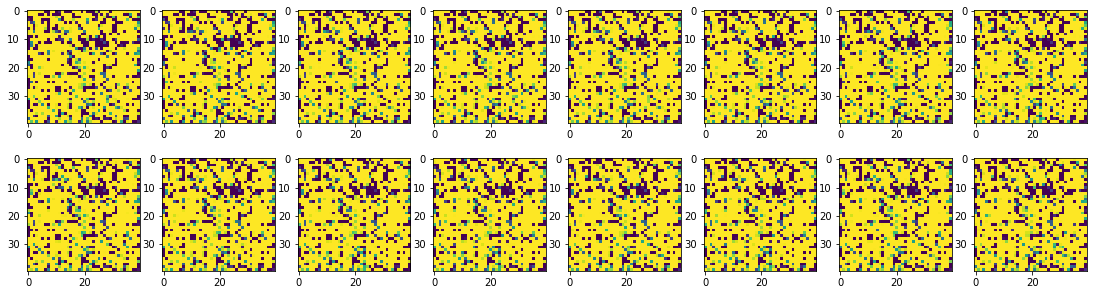

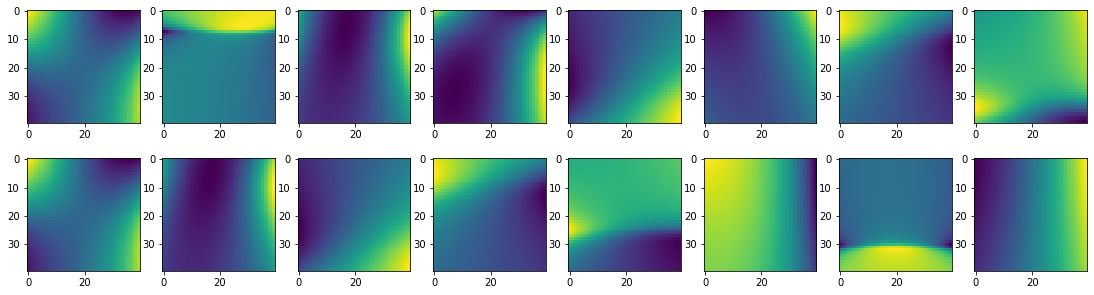

In [7]:
fig, axes = plt.subplots(2, 8, figsize=(19,5))
for i in range(2):
  for j in range(8):
    out = dcgan.generator.predict(np.reshape(np.random.normal(0,1,2),(1,2)))
    axes[i,j].imshow(out[0,:,:,0])
    
fig, axes = plt.subplots(2, 8, figsize=(19,5))
for i in range(2):
  for j in range(8):
    axes[i,j].imshow(polydata[i*j+j])

#### Wasserstein GAN  
[Paper](https://arxiv.org/pdf/1701.07875.pdf)

In [ ]:
from tensorflow.keras import backend as K


class WGAN():
    def __init__(self):
        self.img_rows = 40
        self.img_cols = 40
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 10
        self.clip_value = 0.03
        optimizer = RMSprop(lr=0.00003)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 10 * 10, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((10, 10, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        x=8
        model.add(Conv2D(x*16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        # (X_train, _), (_, _) = mnist.load_data()
        X_train = polydata

        # Rescale -1 to 1
        # X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = -np.ones((batch_size, 1))

        for epoch in range(epochs):

            self.critic.trainable = True
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            #self.critic.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print(epoch)
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/wgan_poly_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
wgan.train(epochs=4000, batch_size=32, sample_interval=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 20, 128)       1280      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 256)       295168    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 11, 11, 256)      

90 [D loss: 29.330368] [G loss: 15.037650]
91 [D loss: 29.472940] [G loss: 13.090176]
92 [D loss: 29.568085] [G loss: 13.946405]
93 [D loss: 29.597328] [G loss: 14.582315]
94 [D loss: 29.747904] [G loss: 13.640163]
95 [D loss: 29.791874] [G loss: 13.335698]
96 [D loss: 29.872311] [G loss: 14.910933]
97 [D loss: 29.963200] [G loss: 12.914980]
98 [D loss: 30.023430] [G loss: 12.191520]
99 [D loss: 30.114307] [G loss: 13.420373]
100 [D loss: 30.137611] [G loss: 14.489035]
101 [D loss: 30.184372] [G loss: 12.324512]
102 [D loss: 30.291777] [G loss: 12.297762]
103 [D loss: 30.325634] [G loss: 11.131187]
104 [D loss: 30.388981] [G loss: 11.950342]
105 [D loss: 30.394278] [G loss: 12.170143]
106 [D loss: 30.482935] [G loss: 11.744065]
107 [D loss: 30.556482] [G loss: 10.484183]
108 [D loss: 30.536459] [G loss: 12.015324]
109 [D loss: 30.584457] [G loss: 11.714474]
110 [D loss: 30.670277] [G loss: 10.635005]
111 [D loss: 30.659380] [G loss: 10.609187]
112 [D loss: 30.651905] [G loss: 11.023350

In [ ]:
fig, axes = plt.subplots(2, 8, figsize=(19,5))
for i in range(2):
    for j in range(8):
        out = wgan.generator.predict(np.reshape(np.random.normal(0,1,10),(1,10)))
        axes[i,j].imshow(out[0,:,:,0])
    
fig, axes = plt.subplots(2, 8, figsize=(19,5))
for i in range(2):
    for j in range(8):
        axes[i,j].imshow(polydata[i*j+j])